In [2]:
import openml
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import brier_score_loss
# from alive_progress import alive_bar
import json
import warnings
warnings.filterwarnings("ignore")
import copy


random_state = 42

In [3]:
# read json file with random search results
# import best defaults from json
with open('data/best_defaults_random_search.json') as json_file:
    best_defaults = json.load(json_file)

# read pickle file with bayes search results
bayes_results = pd.read_csv('data/bayes_search_results.csv').drop(columns=['Unnamed: 0'])


In [4]:
best_defaults

{'lgbm': [{'n_estimators': 461,
   'max_depth': 6,
   'learning_rate': 0.020997940641181385,
   'subsample': 0.8340480910424313,
   'min_child_weight': 5,
   'num_leaves': 4,
   'reg_alpha': 1.2683167745409016,
   'reg_lambda': 9.599077378039295},
  {'AUC': {'credit_g': 0.7408,
    'bank-marketing': 0.6568177638392814,
    'MagicTelescope': 0.8604995265151514,
    'Titanic': 0.8331483094910205},
   'Accuracy': {'credit_g': 0.72,
    'bank-marketing': 0.883,
    'MagicTelescope': 0.821,
    'Titanic': 0.7697974217311234},
   'Brier': {'credit_g': 0.18052918319273423,
    'bank-marketing': 0.09963649943775783,
    'MagicTelescope': 0.13285273951059576,
    'Titanic': 0.1595723595274648}}],
 'rfc': [{'n_estimators': 352,
   'max_depth': 3,
   'min_samples_split': 9,
   'min_samples_leaf': 1,
   'max_features': 0.5546548068068401},
  {'AUC': {'credit_g': 0.7398285714285715,
    'bank-marketing': 0.6672329180822952,
    'MagicTelescope': 0.8533928696689113,
    'Titanic': 0.8425634467833957

In [5]:
bayes_results.groupby(['Model', 'Metric']).agg({
    'Value': ['mean', 'std', 'max', 'min','count']
})

Value                                    
                    mean       std       max       min count
Model Metric                                                
lgbm  AUC       0.767263  0.082095  0.864248  0.636854   200
      Accuracy  0.796049  0.061227  0.883000  0.702000   200
      Brier     0.144965  0.030175  0.188722  0.099785   200
rfc   AUC       0.771829  0.080951  0.861080  0.619319   200
      Accuracy  0.791003  0.065851  0.884000  0.698000   200
      Brier     0.147454  0.031788  0.193131  0.099353   200
xgb   AUC       0.766746  0.083319  0.867937  0.638853   200
      Accuracy  0.794783  0.064116  0.883000  0.680000   200
      Brier     0.145006  0.031038  0.189572  0.099464   200

In [6]:
matrix = [[i // 3 for i in range(0, 150)] for i in range(12)]
flattened_matrix = [element for row in matrix for element in row]

In [7]:
bayes_results['iteration'] = flattened_matrix
bayes_results

,Dataset,Model,Hyperparameters,ID,Metric,Value,BayesHyperparameters,Search,iteration
0,credit_g,xgb,NaN,0,AUC,0.739686,"OrderedDict([('gamma', 0.18948799183778545), (...",Bayes,0
1,credit_g,xgb,NaN,0,Accuracy,0.722000,"OrderedDict([('gamma', 0.18948799183778545), (...",Bayes,0
2,credit_g,xgb,NaN,0,Brier,0.180897,"OrderedDict([('gamma', 0.18948799183778545), (...",Bayes,0
3,credit_g,xgb,NaN,1,AUC,0.716000,"OrderedDict([('gamma', 1.0), ('learning_rate',...",Bayes,1
4,credit_g,xgb,NaN,1,Accuracy,0.680000,"OrderedDict([('gamma', 1.0), ('learning_rate',...",Bayes,1
...,...,...,...,...,...,...,...,...,...
1795,Titanic,rfc,NaN,598,Accuracy,0.779006,"OrderedDict([('max_depth', 9), ('max_features'...",Bayes,48
1796,Titanic,rfc,NaN,598,Brier,0.155326,"OrderedDict([('max_depth', 9), ('max_features'...",Bayes,48
1797,Titanic,rfc,NaN,599,AUC,0.838629,"OrderedDict([('max_depth', 3), ('max_features'...",Bayes,49
1798,Titanic,rfc,NaN,599,Accuracy,0.777164,"OrderedDict([('max_depth', 3), ('max_features'...",Bayes,49


In [8]:
grouped_bayes_results = bayes_results.groupby(['Model', 'Metric', 'Dataset']).agg({
    'Value': ['mean', 'std','max', 'min','count']
})

In [9]:
grouped_bayes_results

Value                                    
                                   mean       std       max       min count
Model Metric   Dataset                                                     
lgbm  AUC      MagicTelescope  0.856709  0.005696  0.864248  0.842595    50
               Titanic         0.829565  0.004563  0.843041  0.815920    50
               bank-marketing  0.650716  0.005924  0.661091  0.636854    50
               credit_g        0.732064  0.005798  0.740790  0.722857    50
      Accuracy MagicTelescope  0.814260  0.006480  0.823000  0.793000    50
               Titanic         0.768656  0.007857  0.788214  0.755064    50
               bank-marketing  0.883000  0.000000  0.883000  0.883000    50
               credit_g        0.718280  0.011429  0.734000  0.702000    50
      Brier    MagicTelescope  0.137449  0.005263  0.154529  0.132432    50
               Titanic         0.160710  0.002095  0.169800  0.156133    50
               bank-marketing  0.100546  0.000450  0.102177  0.099785    50
               credit_g        0.181155  0.002294  0.188722  0.178389    50
rfc   AUC      MagicTelescope  0.849458  0.008443  0.861080  0.820308    50
               Titanic         0.841175  0.003963  0.845388  0.822426    50
               bank-marketing  0.652436  0.010599  0.671671  0.619319    50
               credit_g        0.744247  0.006015  0.750610  0.721524    50
      Accuracy MagicTelescope  0.805520  0.006329  0.814000  0.782000    50
               Titanic         0.775433  0.003634  0.784530  0.769797    50
               bank-marketing  0.883020  0.000141  0.884000  0.883000    50
               credit_g        0.700040  0.003511  0.718000  0.698000    50
      Brier    MagicTelescope  0.143563  0.005951  0.157324  0.132109    50
               Titanic         0.157921  0.003002  0.170334  0.155034    50
               bank-marketing  0.100409  0.000533  0.101931  0.099353    50
               credit_g        0.187924  0.001447  0.193131  0.183295    50
xgb   AUC      MagicTelescope  0.858445  0.006174  0.867937  0.841483    50
               Titanic         0.830789  0.005475  0.836999  0.814248    50
               bank-marketing  0.651565  0.008208  0.664440  0.638853    50
               credit_g        0.726187  0.008743  0.740819  0.711400    50
      Accuracy MagicTelescope  0.815040  0.008699  0.829000  0.796000    50
               Titanic         0.771971  0.006053  0.786372  0.753223    50
               bank-marketing  0.883000  0.000000  0.883000  0.883000    50
               credit_g        0.709120  0.014292  0.734000  0.680000    50
      Brier    MagicTelescope  0.136140  0.004097  0.146847  0.130697    50
               Titanic         0.160096  0.002161  0.167236  0.157794    50
               bank-marketing  0.100184  0.000455  0.101827  0.099464    50
               credit_g        0.183604  0.002818  0.189572  0.178518    50

In [10]:
best_defaults['lgbm'][1]['AUC']


{'credit_g': 0.7408,
 'bank-marketing': 0.6568177638392814,
 'MagicTelescope': 0.8604995265151514,
 'Titanic': 0.8331483094910205}

In [11]:
#
grouped_bayes_results.loc[('lgbm', 'AUC'), ('Value', 'max')]

# make this a dict


Dataset
MagicTelescope    0.864248
Titanic           0.843041
bank-marketing    0.661091
credit_g          0.740790
Name: (Value, max), dtype: float64

In [12]:

model_type = 'lgbm'
metric = 'AUC'
dataset = 'credit_g'

In [13]:
(-best_defaults[model_type][1][metric][dataset] + grouped_bayes_results.loc[(model_type, metric, dataset), ('Value', 'max')])

-9.523809523792615e-06

In [14]:
grouped_bayes_results

Value                                    
                                   mean       std       max       min count
Model Metric   Dataset                                                     
lgbm  AUC      MagicTelescope  0.856709  0.005696  0.864248  0.842595    50
               Titanic         0.829565  0.004563  0.843041  0.815920    50
               bank-marketing  0.650716  0.005924  0.661091  0.636854    50
               credit_g        0.732064  0.005798  0.740790  0.722857    50
      Accuracy MagicTelescope  0.814260  0.006480  0.823000  0.793000    50
               Titanic         0.768656  0.007857  0.788214  0.755064    50
               bank-marketing  0.883000  0.000000  0.883000  0.883000    50
               credit_g        0.718280  0.011429  0.734000  0.702000    50
      Brier    MagicTelescope  0.137449  0.005263  0.154529  0.132432    50
               Titanic         0.160710  0.002095  0.169800  0.156133    50
               bank-marketing  0.100546  0.000450  0.102177  0.099785    50
               credit_g        0.181155  0.002294  0.188722  0.178389    50
rfc   AUC      MagicTelescope  0.849458  0.008443  0.861080  0.820308    50
               Titanic         0.841175  0.003963  0.845388  0.822426    50
               bank-marketing  0.652436  0.010599  0.671671  0.619319    50
               credit_g        0.744247  0.006015  0.750610  0.721524    50
      Accuracy MagicTelescope  0.805520  0.006329  0.814000  0.782000    50
               Titanic         0.775433  0.003634  0.784530  0.769797    50
               bank-marketing  0.883020  0.000141  0.884000  0.883000    50
               credit_g        0.700040  0.003511  0.718000  0.698000    50
      Brier    MagicTelescope  0.143563  0.005951  0.157324  0.132109    50
               Titanic         0.157921  0.003002  0.170334  0.155034    50
               bank-marketing  0.100409  0.000533  0.101931  0.099353    50
               credit_g        0.187924  0.001447  0.193131  0.183295    50
xgb   AUC      MagicTelescope  0.858445  0.006174  0.867937  0.841483    50
               Titanic         0.830789  0.005475  0.836999  0.814248    50
               bank-marketing  0.651565  0.008208  0.664440  0.638853    50
               credit_g        0.726187  0.008743  0.740819  0.711400    50
      Accuracy MagicTelescope  0.815040  0.008699  0.829000  0.796000    50
               Titanic         0.771971  0.006053  0.786372  0.753223    50
               bank-marketing  0.883000  0.000000  0.883000  0.883000    50
               credit_g        0.709120  0.014292  0.734000  0.680000    50
      Brier    MagicTelescope  0.136140  0.004097  0.146847  0.130697    50
               Titanic         0.160096  0.002161  0.167236  0.157794    50
               bank-marketing  0.100184  0.000455  0.101827  0.099464    50
               credit_g        0.183604  0.002818  0.189572  0.178518    50

## Init result dict (gets overriden otherwise) 

In [15]:
dataset_strs = ["credit_g", "bank-marketing", "MagicTelescope", "Titanic"]
metrics = ['AUC', 'Accuracy', 'Brier']
model_types = ['lgbm', 'rfc', 'xgb']
tunability = dict.fromkeys(model_types, dict.fromkeys(metrics, 0))
for model_type in model_types:
    for metric in metrics:
        tunability[model_type][metric] = 0

import copy as cp
print(tunability)
# update lgbm AUC to 0.1 leave the rest
temp_dict = cp.deepcopy(tunability['lgbm'])
temp_dict['AUC'] = 0.1
tunability.update({'lgbm': temp_dict})

temp_dict = cp.deepcopy(tunability['xgb'])
temp_dict['AUC'] = 0.2
tunability.update({'xgb': temp_dict})

print(tunability)


{'lgbm': {'AUC': 0, 'Accuracy': 0, 'Brier': 0}, 'rfc': {'AUC': 0, 'Accuracy': 0, 'Brier': 0}, 'xgb': {'AUC': 0, 'Accuracy': 0, 'Brier': 0}}
{'lgbm': {'AUC': 0.1, 'Accuracy': 0, 'Brier': 0}, 'rfc': {'AUC': 0, 'Accuracy': 0, 'Brier': 0}, 'xgb': {'AUC': 0.2, 'Accuracy': 0, 'Brier': 0}}


## Create result dict

In [16]:

for model_type in model_types:
    for metric in metrics:
        tunability_temp = np.array([])
        # if model_type not in tunability:
        #         tunability[model_type] = {}
        #         if metric not in tunability[model_type]:
        #             tunability[model_type][metric] = np.array([])
        
        for dataset in dataset_strs:
            
            if metric!='Brier':
                mutliplier = 1
                res = (-best_defaults[model_type][1][metric][dataset] + grouped_bayes_results.loc[(model_type, metric, dataset), ('Value', 'max')])*mutliplier
                tunability_temp = np.append(tunability_temp, res)
            else:
                mutliplier = -1
                res = (-best_defaults[model_type][1][metric][dataset] + grouped_bayes_results.loc[(model_type, metric, dataset), ('Value', 'min')])*mutliplier
                tunability_temp = np.append(tunability_temp, res)

        temp_dict = cp.deepcopy(tunability[model_type])
        temp_dict[metric] = cp.deepcopy(tunability_temp.tolist())
        tunability[model_type].update(temp_dict)


        # print(tunability_temp)
        
with open('data/tunability_stats.json', 'w') as fp:
    json.dump(tunability, fp)
tunability

{'lgbm': {'AUC': [-9.523809523792615e-06,
   0.004273504273504258,
   0.0037484217171718237,
   0.00989292037885392],
  'Accuracy': [0.014000000000000012,
   0.0,
   0.0020000000000000018,
   0.018416206261510082],
  'Brier': [0.002139723024632223,
   -0.00014849051735316143,
   0.00042077146635405294,
   0.0034390656813163833]},
 'rfc': {'AUC': [0.010780952380952336,
   0.004438055966934806,
   0.007687552609427661,
   0.0028245411877125814],
  'Accuracy': [-0.016000000000000014,
   0.0010000000000000009,
   0.0039999999999998925,
   0.0055248618784530246],
  'Brier': [-0.003330795899811917,
   -0.0007076485366494939,
   0.008543232018340619,
   0.0004211496625398381]},
 'xgb': {'AUC': [0.003933333333333455,
   -0.004162189892654267,
   0.011392133136924776,
   -0.0034217700458109013],
  'Accuracy': [0.010000000000000009,
   0.0,
   0.014000000000000012,
   0.012891344383057057],
  'Brier': [0.002255780476932784,
   -0.00017878287575455454,
   0.004975908170321536,
   -0.0017795932774

## Make boxplots

lgbm AUC [-9.523809523792615e-06, 0.004273504273504258, 0.0037484217171718237, 0.00989292037885392] 0.004476330640001552

rfc AUC [0.010780952380952336, 0.004438055966934806, 0.007687552609427661, 0.0028245411877125814] 0.006432775536256846

xgb AUC [0.003933333333333455, -0.004162189892654267, 0.011392133136924776, -0.0034217700458109013] 0.0019353766329482658



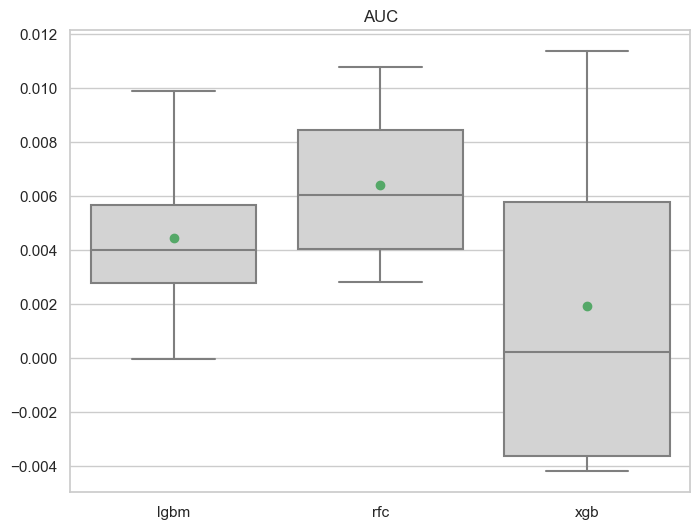

lgbm Accuracy [0.014000000000000012, 0.0, 0.0020000000000000018, 0.018416206261510082] 0.008604051565377524

rfc Accuracy [-0.016000000000000014, 0.0010000000000000009, 0.0039999999999998925, 0.0055248618784530246] -0.001368784530386774

xgb Accuracy [0.010000000000000009, 0.0, 0.014000000000000012, 0.012891344383057057] 0.00922283609576427



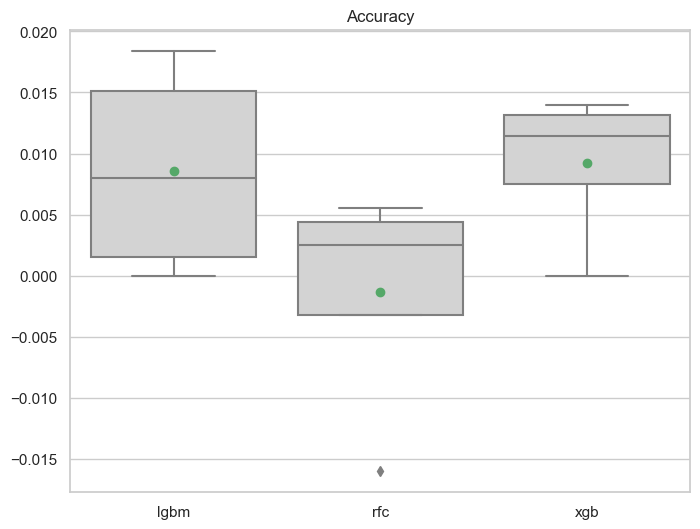

lgbm Brier [0.002139723024632223, -0.00014849051735316143, 0.00042077146635405294, 0.0034390656813163833] 0.0014627674137373745

rfc Brier [-0.003330795899811917, -0.0007076485366494939, 0.008543232018340619, 0.0004211496625398381] 0.0012314843111047614

xgb Brier [0.002255780476932784, -0.00017878287575455454, 0.004975908170321536, -0.0017795932774880285] 0.0013183281235029341



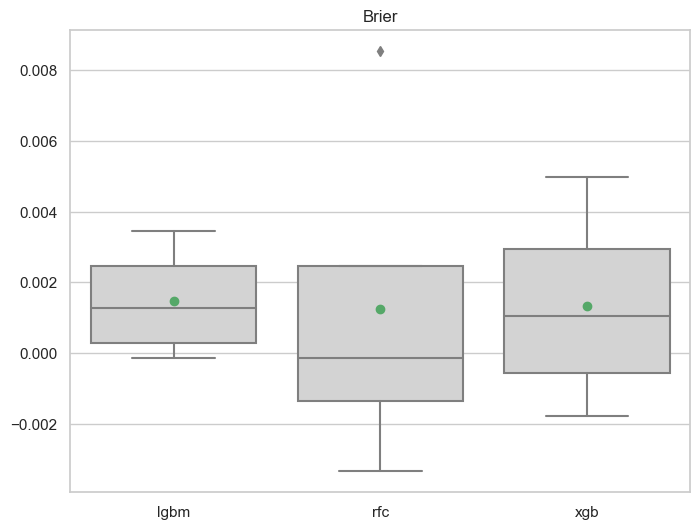

In [25]:
# for each metric create boxplots of the results from tunability dict by model type 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

for metric in metrics:
    data = []
    for model_type in tunability:
        data.append(tunability[model_type][metric])
        print(model_type, metric, tunability[model_type][metric], np.mean(tunability[model_type][metric]), end='\n\n')
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(data=data, color='lightgrey', showmeans=True, meanprops={"marker":"o",})
    ax.set_xticklabels(list(tunability.keys()))
    ax.set_title(metric)
    plt.savefig(f'plots/tunability_{metric}.png')
    plt.show()


In [18]:
# create dict with mean tunability for each model type and metric
mean_tunability = {}
for model_type in tunability:
    for metric in tunability[model_type]:
        if model_type not in mean_tunability:
            mean_tunability[model_type] = {}
        mean_tunability[model_type][metric] = np.mean(tunability[model_type][metric])
mean_tunability


{'lgbm': {'AUC': 0.004476330640001552,
  'Accuracy': 0.008604051565377524,
  'Brier': 0.0014627674137373745},
 'rfc': {'AUC': 0.006432775536256846,
  'Accuracy': -0.001368784530386774,
  'Brier': 0.0012314843111047614},
 'xgb': {'AUC': 0.0019353766329482658,
  'Accuracy': 0.00922283609576427,
  'Brier': 0.0013183281235029341}}

In [19]:
with open('data/max_tunability.json', 'w') as fp:
    json.dump(mean_tunability, fp)

In [20]:
tunability

{'lgbm': {'AUC': [-9.523809523792615e-06,
   0.004273504273504258,
   0.0037484217171718237,
   0.00989292037885392],
  'Accuracy': [0.014000000000000012,
   0.0,
   0.0020000000000000018,
   0.018416206261510082],
  'Brier': [0.002139723024632223,
   -0.00014849051735316143,
   0.00042077146635405294,
   0.0034390656813163833]},
 'rfc': {'AUC': [0.010780952380952336,
   0.004438055966934806,
   0.007687552609427661,
   0.0028245411877125814],
  'Accuracy': [-0.016000000000000014,
   0.0010000000000000009,
   0.0039999999999998925,
   0.0055248618784530246],
  'Brier': [-0.003330795899811917,
   -0.0007076485366494939,
   0.008543232018340619,
   0.0004211496625398381]},
 'xgb': {'AUC': [0.003933333333333455,
   -0.004162189892654267,
   0.011392133136924776,
   -0.0034217700458109013],
  'Accuracy': [0.010000000000000009,
   0.0,
   0.014000000000000012,
   0.012891344383057057],
  'Brier': [0.002255780476932784,
   -0.00017878287575455454,
   0.004975908170321536,
   -0.0017795932774